# Simple RNN

### 시계열 데이터와 RNN
- 시계열 데이터는 과거 현재가 종속 관계에 있다.
- RNN은 시계열 데이터, 자연어 데이터 등에 널리 활용된다.

- 과거의 출력 정보가 현재의 입력 데이터와 함께 다시 입력된다 => 재귀적 구조

# Simple RNN : 공통 데이터 준비 부분

In [49]:
from keras.layers import Dense, Input, SimpleRNN
from keras.models import Model
from keras.optimizers.legacy import Adam
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# 2D의 feature 데이터로 3D의 학습 데이터를 만들기
def build_rnn_data(data, t_step, n_jump=1):
    n_data = data.shape[0] # number of data
    m = np.arange(0, n_data - t_step, n_jump)
    x = np.array([data[i:(i+t_step), :] for i in m]) # feature data
    y = np.array([data[i, :] for i in (m + t_step)]) # target data
    return x, y

In [51]:
# 시계열 데이터 (noisy sin 2개)
n = 1000
s1 = np.sin(np.pi * 0.06 * np.arange(n)) + np.random.random(n)
s2 = 0.5*np.sin(np.pi * 0.05 * np.arange(n)) + np.random.random(n)
data = np.vstack([s1,s2]).T

In [52]:
# 학습 데이터 생성
t_step = 20
x_train, y_train = build_rnn_data(data, t_step)

In [67]:
# 모델 생성하기 위한 레이어 설정
n_input = x_train.shape[-1]
n_output = y_train.shape[-1]
n_hidden = 50

# Simple RNN - Many to One : Keras 이용 모델 생성

In [69]:
# Simple RNN 모델 생성하기
x_input = Input(batch_shape=(None, t_step, n_input))
h = SimpleRNN(n_hidden)(x_input)
y_output = Dense(n_output)(h)

model = Model(x_input, y_output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 20, 2)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                2650      
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2752 (10.75 KB)
Trainable params: 2752 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
# trainable parameter의 개수:
# wx = 2 * 50 = 100개
# bias = 50개
# y_output의 w = 50 * 2 = 100개
# y_output의 bias = 2개
# total = 150 + 2500 + 102 = 2752개

In [71]:
# 학습하기
hist = model.fit(x_train, y_train, epochs=50, batch_size=50, shuffle=True)

Epoch 1/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4705
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1704
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1393
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1239
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1166
Epoch 6/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1131
Epoch 7/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1090
Epoch 8/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1064
Epoch 9/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1032
Epoch 10/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1013
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1017
Epoch 12/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1006
Epoch 13/50
20/20 [==============================

In [72]:
# 향후 50 기간 데이터를 예측한다. 향후 1 기간을 예측하고,
# 예측값을 다시 입력하여 2기간을 예측한다.
# 이런 방식으로 50기간까지 예측한다.
n_future = 50
n_last = 100
last_data = data[-n_last:] # 원본 데이터의 마지막 n_last개만 그려보기
for i in range(n_future):
    # 마지막 t_step만큼 입력 데이터로 다음 값을 예측한다.
    px = last_data[-t_step:, :].reshape(1, t_step, 2)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px,verbose=0)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기 위해 예측한 값을 지정해 둔다.
    last_data = np.vstack([last_data, y_hat])

p = last_data[:-n_future, :]     # past data
f = last_data[-(n_future+1):, :] # future data

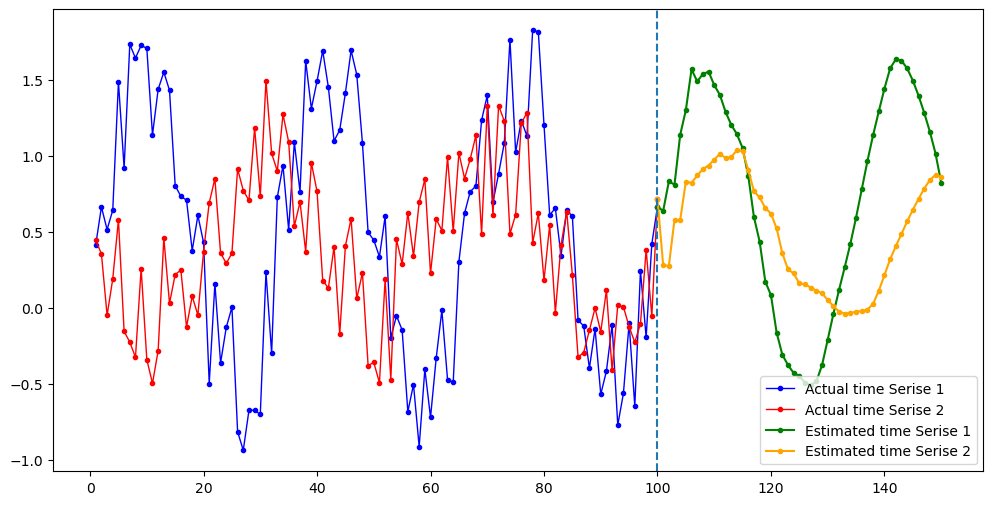

In [73]:
# 원본 시계열과 예측된 시계열을 그려본다.
plt.figure(figsize=(12,6))
ax1 = np.arange(1, len(p) + 1)
ax2 = np.arange(len(p), len(p) + len(f))
plt.plot(ax1, p[:, 0], '-o', c='blue', markersize=3, label='Actual time Serise 1', linewidth=1)
plt.plot(ax1, p[:, 1], '-o', c='red', markersize=3, label='Actual time Serise 2', linewidth=1)
plt.plot(ax2, f[:, 0], '-o', c='green', markersize=3, label='Estimated time Serise 1')
plt.plot(ax2, f[:, 1], '-o', c='orange', markersize=3, label='Estimated time Serise 2')

plt.axvline(x=ax1[-1], linestyle='dashed')
plt.legend()
plt.show()

# Simple RNN - Many to One : from scratch 모델 생성

In [61]:
# Simple RNN 기능 구현
class MySimpleRNN(Layer):
    # nf : feature 개수, nh : hidden unit 개수
    def __init__(self, nf, nh):
        super().__init__()
        self.nh = nh
        w_init = tf.random_normal_initializer()
        b_init = tf.zeros_initializer()
        
        self.wx = tf.Variable(w_init([nf, nh]), trainable = True)
        self.wh = tf.Variable(w_init([nh, nh]), trainable = True)
        self.b = tf.Variable(b_init([1, nh]), trainable = True)
        
    def call(self, x):
        h = tf.zeros(shape=(1, self.nh)) # 초기화
        # time step만큼 recurrent 수행
        for t in range(x.shape[1]):
            # shape : [None, nf]*[nf,nh] + [1,ng]*[nh,nh] + [1,nh]
            z = tf.matmul(x[:, t, :], self.wx) + tf.matmul(h,self.wh) + self.b
            h = tf.math.tanh(z)
        return h

In [62]:
# RNN 모델 생성
x_input = Input(batch_shape=(None, t_step, n_input))
h = MySimpleRNN(n_input, n_hidden)(x_input)
y_output = Dense(n_output, activation='linear')(h)

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 2)]           0         
                                                                 
 my_simple_rnn_5 (MySimpleR  (None, 50)                2650      
 NN)                                                             
                                                                 
 dense_4 (Dense)             (None, 2)                 102       
                                                                 
Total params: 2752 (10.75 KB)
Trainable params: 2752 (10.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
# 학습하기
hist = model.fit(x_train, y_train, epochs=50, batch_size=50)

Epoch 1/50
20/20 [==============================] - 0s 1ms/step - loss: 0.2986
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1523
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1390
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1340
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1301
Epoch 6/50
20/20 [==============================] - 0s 914us/step - loss: 0.1234
Epoch 7/50
20/20 [==============================] - 0s 890us/step - loss: 0.1171
Epoch 8/50
20/20 [==============================] - 0s 946us/step - loss: 0.1137
Epoch 9/50
20/20 [==============================] - 0s 902us/step - loss: 0.1110
Epoch 10/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1107
Epoch 11/50
20/20 [==============================] - 0s 994us/step - loss: 0.1121
Epoch 12/50
20/20 [==============================] - 0s 936us/step - loss: 0.1099
Epoch 13/50
20/20 [==================

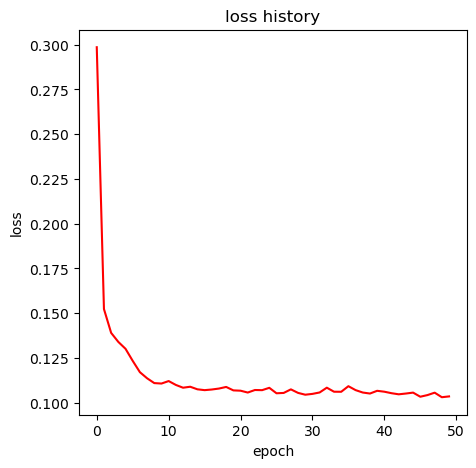

In [64]:
# loss history 시각화
plt.figure(figsize=(5,5))
plt.plot(hist.history['loss'], color='red')
plt.title("loss history")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [65]:
# 향후 50 기간 데이터를 예측한다. 향후 1 기간을 예측하고,
# 예측값을 다시 입력하여 2기간을 예측한다.
# 이런 방식으로 50기간까지 예측한다.
n_future = 50
n_last = 100
last_data = data[-n_last:] # 원본 데이터의 마지막 n_last개만 그려보기
for i in range(n_future):
    # 마지막 t_step만큼 입력 데이터로 다음 값을 예측한다.
    px = last_data[-t_step:, :].reshape(1, t_step, 2)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px,verbose=0)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기 위해 예측한 값을 지정해 둔다.
    last_data = np.vstack([last_data, y_hat])

p = last_data[:-n_future, :]     # past data
f = last_data[-(n_future+1):, :] # future data

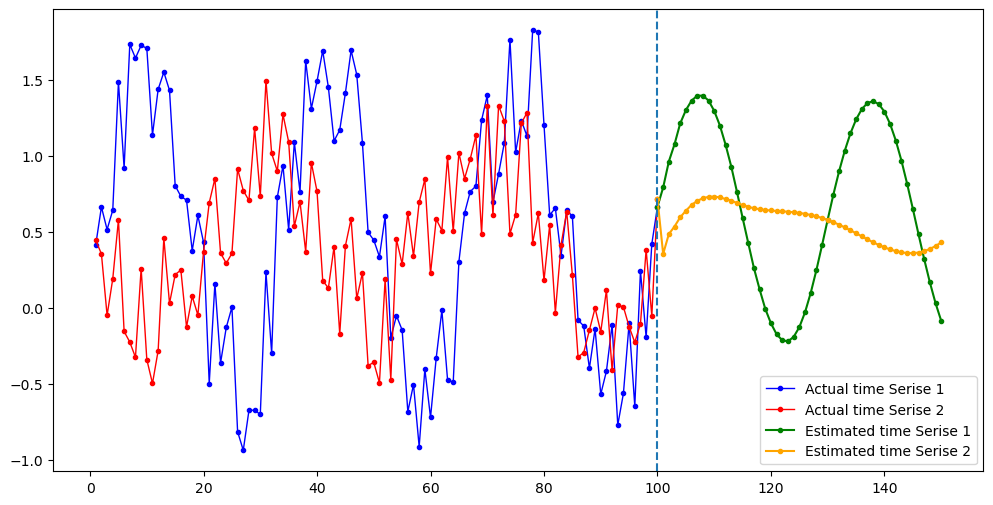

In [66]:
# 원본 시계열과 예측된 시계열을 그려본다.
plt.figure(figsize=(12,6))
ax1 = np.arange(1, len(p) + 1)
ax2 = np.arange(len(p), len(p) + len(f))
plt.plot(ax1, p[:, 0], '-o', c='blue', markersize=3, label='Actual time Serise 1', linewidth=1)
plt.plot(ax1, p[:, 1], '-o', c='red', markersize=3, label='Actual time Serise 2', linewidth=1)
plt.plot(ax2, f[:, 0], '-o', c='green', markersize=3, label='Estimated time Serise 1')
plt.plot(ax2, f[:, 1], '-o', c='orange', markersize=3, label='Estimated time Serise 2')

plt.axvline(x=ax1[-1], linestyle='dashed')
plt.legend()
plt.show()